In [65]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
import re

In [4]:
input_file = "ham_lyrics.csv"

In [5]:
df = pd.read_csv(input_file,encoding = "ISO-8859-1")

In [6]:
df.head()

,title,speaker,lines
0,Alexander Hamilton,BURR,"How does a bastard, orphan, son of a whore and a"
1,Alexander Hamilton,BURR,"Scotsman, dropped in the middle of a forgotten"
2,Alexander Hamilton,BURR,"Spot in the Caribbean by providence, impoveris..."
3,Alexander Hamilton,BURR,Grow up to be a hero and a scholar?
4,Alexander Hamilton,LAURENS,The ten-dollar Founding Father without a father


In [7]:
df['title'].value_counts().sort_index()

title
A Winter's Ball                               26
Aaron Burr, Sir                               66
Alexander Hamilton                            82
Best of Wives and Best of Women               12
Blow Us All Away                              81
Burn                                          54
Cabinet Battle #1                             78
Cabinet Battle #2                             62
Dear Theodosia                                39
Farmer Refuted                                48
Guns and Ships                                61
Helpless                                     125
History Has Its Eyes On You                   30
Hurricane                                     46
I Know Him                                    28
It's Quiet Uptown                             62
Meet Me Inside                                48
My Shot                                      188
Non-Stop                                     195
One Last Time                                103
Right Hand Man

In [16]:
# Filter Data with more than 3 words
df = df[df['lines'].apply(lambda x: len(x.split(" ")) > 3)]

In [19]:
punct = re.compile(r'[!\\"#$%&\'()*+,-./:;<=>?@\[\]^_`{|}~0-9]+') #puctuation regex

In [25]:
#freq count after data processing
cv = text.CountVectorizer(lowercase=True,preprocessor=lambda x: punct.sub("",x.strip()).lower(),stop_words='english')

In [26]:
op = cv.fit_transform(df["lines"])

In [27]:
df_freq = pd.DataFrame(op.toarray(),columns=cv.get_feature_names_out())

In [28]:
df_freq.head()

,aafter,aaron,abandon,abandonin,abet,abilities,ability,abolitionists,abrasive,absolutely,...,yorkers,yorks,yorktown,youd,youll,young,younger,youre,youve,zeal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
freq_words = df_freq.sum(axis=0)

In [30]:
freq_words.sort_values(ascending=False)

im           181
know          98
da            87
dont          76
room          70
            ... 
diuretic       1
pa             1
overwhelm      1
overcame       1
aafter         1
Length: 2533, dtype: int64

In [70]:
mask = np.array(Image.open('Daco_4619908.png'))
wc = WordCloud(width=mask.shape[1], height=mask.shape[0], mask=mask, background_color="white").generate_from_frequencies(freq_words)

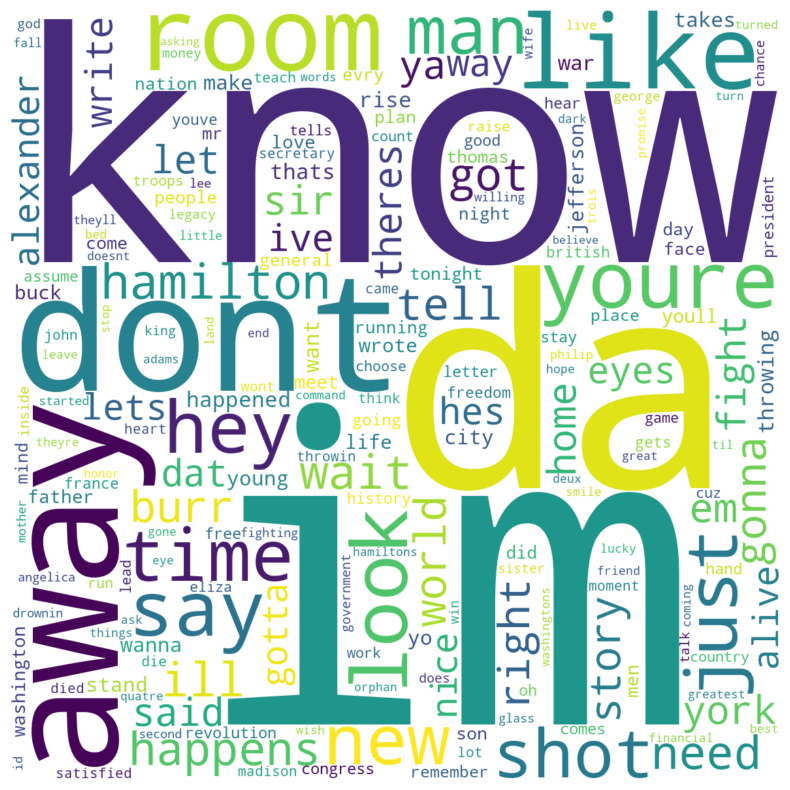

In [76]:
plt.rcParams["figure.figsize"] = (10,10)
plt.axis('off')

plt.imshow(wc, interpolation="bilinear")

In [33]:
#Store processed text in a new column
df['cleaned_lines'] = df['lines'].apply(lambda x: punct.sub("",x.strip()).lower())

In [34]:
#join lines by title
df_song = df.groupby('title',sort=False).apply(lambda x: " ".join(x['cleaned_lines']))

In [35]:
df_song.iloc[0]

'how does a bastard orphan son of a whore and a scotsman dropped in the middle of a forgotten spot in the caribbean by providence impoverished in squalor grow up to be a hero and a scholar the tendollar founding father without a father got a lot farther by working a lot harder by being a lot smarter by being a selfstarter by fourteen they placed him in charge of a trading charter and every day while slaves were being slaughtered and carted away across the waves he struggled and kept his guard up inside he was longing for something to be a part of the brother was ready to beg steal borrow or barter then a hurricane came and devastation reigned our man saw his future drip dripping down the drain put a pencil to his temple connected it to his brain and he wrote his first refrain a testament to his pain well the word got around they said this kid is insane man took up a collection just to send him to the mainland get your education dont forget from whence you came and the worlds gonna know

In [36]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [37]:
num_words = 5000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

In [38]:
tokenizer = Tokenizer(num_words=num_words,oov_token=oov_token)
tokenizer.fit_on_texts(df_song)

In [39]:
seqs = tokenizer.texts_to_sequences(df_song)

In [40]:
n_grams = 11
gram_seqs = []
n_seqs = len(seqs)
for i in seqs:
    n_i = len(i)
    for j in range(n_i-n_grams):
        gram_seqs.append(i[j:j+n_grams])

In [41]:
labels = [i[-1] for i in gram_seqs]
inputs = [i[:-1] for i in gram_seqs]

In [42]:
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from keras import Model
from keras.layers import Dense, Embedding, LSTM, Input, Bidirectional

In [43]:
encoded_labels = to_categorical(labels,num_classes=num_words)

In [44]:
class lyrics_generator(Model):
    def __init__(self):
        super(lyrics_generator,self).__init__()
        self.embedding = Embedding(num_words,64,input_length=n_grams-1)
        self.lstm = Bidirectional(LSTM(20))
        self.dense = Dense(num_words,activation='softmax')

    def call(self,x):
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.dense(x)
        return x

    def model(self):
        x = Input(shape=(n_grams-1))
        return Model(inputs=[x], outputs=self.call(x))

In [45]:
m = lyrics_generator()
dataset = tf.data.Dataset.from_tensor_slices((inputs,encoded_labels)).batch(64)
m.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) ,loss=tf.keras.losses.CategoricalCrossentropy() ,metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [46]:
m.model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 64)            320000    
                                                                 
 bidirectional (Bidirectiona  (None, 40)               13600     
 l)                                                              
                                                                 
 dense (Dense)               (None, 5000)              205000    
                                                                 
Total params: 538,600
Trainable params: 538,600
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = m.fit(dataset,epochs=200,verbose=0)

In [48]:
print("Loss: {} and Accuracy: {}".format(history.history['loss'][-1],history.history['categorical_accuracy'][-1]))

Loss: 0.7099223136901855 and Accuracy: 0.8544139862060547


In [49]:
def write_lyric(text,text_length=10):
    for i in range(text_length):
        seqs_test = tokenizer.texts_to_sequences([text])
        seqs_test = pad_sequences(seqs_test,maxlen=n_grams-1,value=1)
        pred_probs = m(seqs_test)
        index = tf.argmax(pred_probs,axis=1)[0].numpy()
        word = tokenizer.index_word[index]
        text = text+" "+word
    return text

In [50]:
write_lyric("the man")

'the man of the bands sisters would like you just like i'

In [51]:
write_lyric("he was")

'he was great by a toast to much it takes and he'

In [52]:
write_lyric("alexander")

'alexander with jefferson if you you believe and you lies like'

In [53]:
write_lyric("there was")

'there was suffering started power with me with the beginning of the'

In [54]:
write_lyric("it has")

'it has hamilton you do you would be nice it to you'

In [55]:
write_lyric("I am")

'I am not throwin away my talkin soldiers that i am gone'

In [56]:
write_lyric("Eliza")

'Eliza that would be nice it must be nice it to'

In [57]:
write_lyric("sir")

'sir you gonna keep right on you like you would be'

In [58]:
write_lyric("Thomas Jefferson",text_length=50)

'Thomas Jefferson its quiet to survive you for him so the square its planting man with a young man im matter and im willing to get you what are asking me to run for your own done for my way with the count and im drownin in em on the first shot'

In [59]:
write_lyric("I am", text_length=100)

'I am not throwin away my talkin soldiers that i am gone ill be a letter to helpless it goes it im not your part of the north new york headin to new york on the quagmire the people before be back to live for your crew i am stepping every letter along hamilton up man ill stop until not see what youre in the present were in our corner who we got the students sir im not my side she know that have from your votes well well i am not throwing away my shot i am not throwin away my'